Analysis code from PyPSA-BO

https://github.com/CIE-UMSS/PyPSA-BO/blob/main/Results_analysis/EnergyScope-PyPSA/general_analysis.ipynb

In [1]:
#Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)



max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

#Load different networks

base_network= "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources 

added_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec.nc"
n_add = pypsa.Network(added_network) #output from add_electricity. network with electrical parameters added to components in data sources 

simplified_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #output simplyfy_network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = 'C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s_all.nc'
n_cluster = pypsa.Network(clustered_network) #output clustering-network simplified based on number of clusters give

solved_network = r'C:\Users\hie\pe_tan\pypsa-earth\results\2040_base\networks\elec_s_all_ec_lcopt_1h.nc'
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


In [2]:
# System cost in Million EUR/Year

system_cost_million_eur = n.objective / 1e6  # Convert to million EUR/year

# Print the result
print(f"System cost: {system_cost_million_eur:.2f} Million EUR/Year")

System cost: 13063357.97 Million EUR/Year


In [3]:
#check lines

n_solve.lines.capital_cost.sum()


385359.6767738733

In [4]:
n_add.lines.capital_cost.sum()

480816.53976495634

In [5]:
line_expansion_cost = n.lines.capital_cost.sum()-n_simple.lines.capital_cost.sum() # difference between the two networks (Eur/MW)
print("Capital cost for line expansion: " + str(line_expansion_cost/1000000) + " Million Eur")

Capital cost for line expansion: -0.09545686299108307 Million Eur


In [6]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.p_nom


carrier
CCGT          1.192700e+03
OCGT          1.850000e+02
biomass       1.050000e+01
coal          6.000000e+02
geothermal    1.350000e+02
load          6.700000e+10
offwind-ac    0.000000e+00
offwind-dc    0.000000e+00
oil           8.880000e+01
onwind        9.110989e-01
ror           6.017862e+02
solar         1.447202e+01
Name: p_nom, dtype: float64

In [7]:
#optimized

gen_cap.p_nom_opt

carrier
CCGT          1.349813e+03
OCGT          1.850376e+02
biomass       1.130722e+01
coal          6.000053e+02
geothermal    5.585823e+03
load          6.700000e+10
offwind-ac    2.112695e+00
offwind-dc    1.201364e+00
oil           1.017493e+02
onwind        1.722771e+05
ror           6.017862e+02
solar         1.490991e+05
Name: p_nom_opt, dtype: float64

In [8]:
stores_cap = n.storage_units.groupby(["carrier"]).sum()
stores_cap.p_nom_opt

carrier
hydro    4340.625972
Name: p_nom_opt, dtype: float64

In [9]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT             157.113096
OCGT               0.037572
biomass            0.807219
coal               0.005333
geothermal      5450.822558
load               0.000000
offwind-ac         2.112695
offwind-dc         1.201364
oil               12.949327
onwind        172276.144462
ror                0.000000
solar         149084.645453
dtype: float64

In [10]:
generation_expansion.sum()

326985.8390783754

Transmission expansion

In [11]:

n_line = pypsa.Network(base_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


458.9607745961448

In [12]:
lines=n.lines
n.lines.s_nom.mean()

458.9607745961448

In [13]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
0     5.094284e+02
1     7.883081e+01
2     1.060170e+01
3     2.493464e+03
4     1.114528e+02
          ...     
66    4.516821e+02
67   -1.081389e-09
68    4.032354e-02
69    3.171752e+02
70    4.516827e+02
Length: 71, dtype: float64

In [14]:
# Calculate transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']

# Filter for negative values
negative_expansion = transmission_expansion[transmission_expansion < 0]

# Print the negative values
print("Negative transmission expansions:")
print(negative_expansion)

# Count the number of negative values
print(f"Number of negative expansions: {len(negative_expansion)}")

# Sum of negative expansions
print(f"Total negative expansion (MW): {negative_expansion.sum()}")

Negative transmission expansions:
Line
67   -1.081389e-09
dtype: float64
Number of negative expansions: 1
Total negative expansion (MW): -1.0813892004080117e-09


In [15]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 32182.982112099715


In [16]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

2683.336052262691

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\2452526199.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



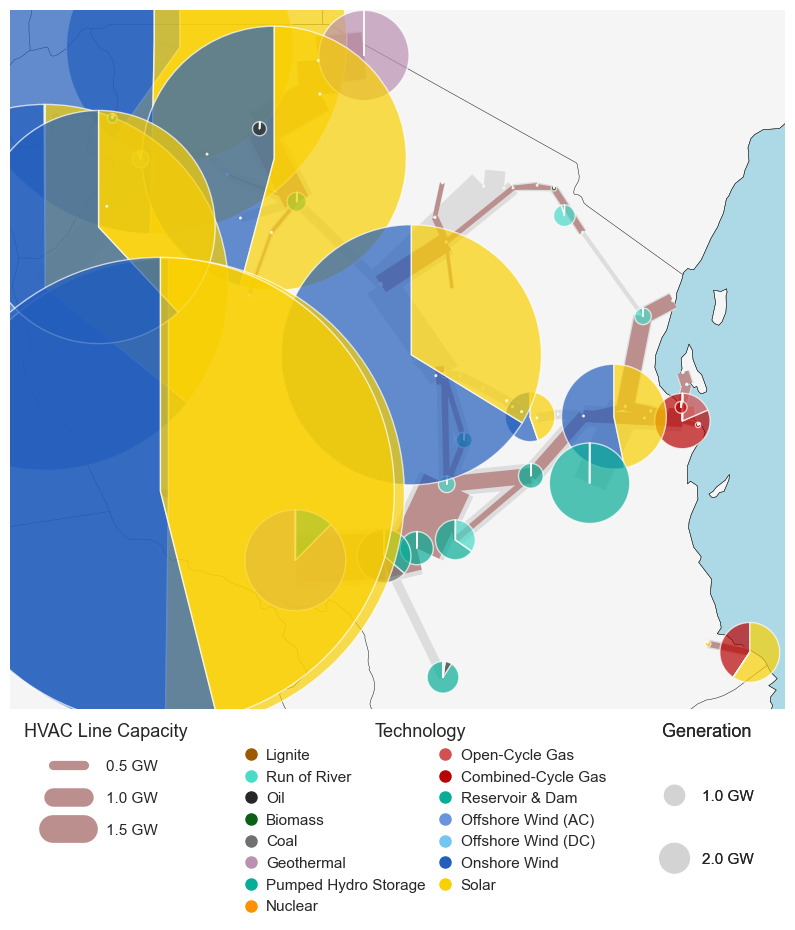

In [17]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    



    add_legend(ax, bus_factor, branch_factor)

    


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [18]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Biomass                 1.130722e+01        1.050000e+01   
            Coal                    6.000053e+02        6.000000e+02   
            Combined-Cycle Gas      1.349813e+03        1.192700e+03   
            Geothermal              5.585823e+03        1.350000e+02   
            Offshore Wind (AC)      2.112695e+00        0.000000e+00   
            Offshore Wind (DC)      1.201364e+00        0.000000e+00   
            Oil                     1.017493e+02        8.880000e+01   
            Onshore Wind            1.722771e+05        9.110989e-01   
            Open-Cycle Gas          1.850376e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   1.490991e+05        1.447202e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      6.476920e+04        3.258621e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Biomass             7.245666e+03  0.000000e+00  7.245666e+03   
            Coal                7.086367e+02  0.000000e+00  7.086367e+02   
            Combined-Cycle Gas  2.086399e+06  0.000000e+00  2.086399e+06   
            Geothermal          4.489858e+07  0.000000e+00  4.489858e+07   
            Offshore Wind (AC)  1.740456e+03  0.000000e+00  1.740456e+03   
            Offshore Wind (DC)  1.428046e+03  0.000000e+00  1.428046e+03   
            Oil                 3.137482e+03  0.000000e+00  3.137482e+03   
            Onshore Wind        4.185343e+06  0.000000e+00  4.185343e+06   
            Open-Cycle Gas      2.773523e+03  0.000000e+00  2.773523e+03   
            Run of River        2.978206e+06  0.000000e+00  2.978206e+06   
            Solar               5.730443e+06  0.000000e+00  5.730443e+06   
            load                1.629190e+06  0.000000e+00  1.629190e+06   
Line        AC                  3.175737e+08  3.175737e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.732481e+07  0.000000e+00  1.732481e+07   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Biomass             0.000000e+00         0.073151  0.000000e+00   
            Coal                0.000000e+00         0.000135  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.176449  0.000000e+00   
            Geothermal          0.000000e+00         0.917574  0.000000e+00   
            Offshore Wind (AC)  0.000000e+00         0.094042  1.848555e+03   
            Offshore Wind (DC)  0.000000e+00         0.135695  1.552604e+03   
            Oil                 0.000000e+00         0.003520  0.000000e+00   
            Onshore Wind        0.000000e+00         0.002773  6.893461e+07   
            Open-Cycle Gas      0.000000e+00         0.001711  0.000000e+00   
            Run of River        0.000000e+00         0.564948  9.969345e+04   
            Solar               0.000000e+00         0.004387  2.063289e+08   
            load                0.000000e+00         0.000003  0.000000e+00   
Line        AC                 -2.733929e+07         0.559721  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.455630  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Biomass                    4.000420e+06             1.147618e+05   
            Coal                       2.649019e+08             2.283526e+04   
            Combined-Cycle Gas         1.703219e+08             9.766965e+07   
            Geothermal                 0.000000e+00             4.095926e+05 

In [19]:
n.statistics.dispatch().sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\3758984340.py:1: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



0.20821502804756165

In [20]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

30619366392.60216

In [21]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

30619.366392602158

In [22]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

13033638.16136229

In [23]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

29719.81051633575

<AxesSubplot:xlabel='snapshot'>

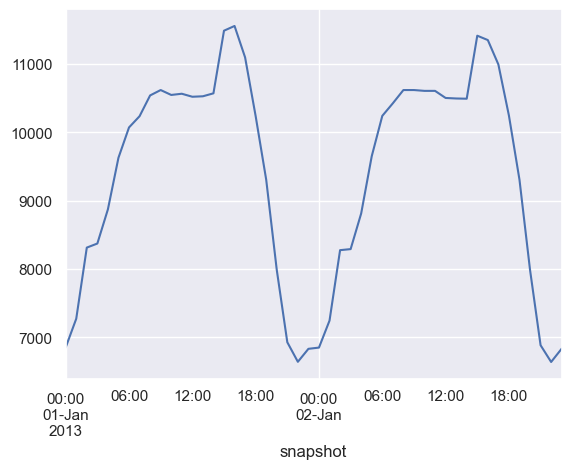

In [24]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

Expansion and generation charts

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\3549183427.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

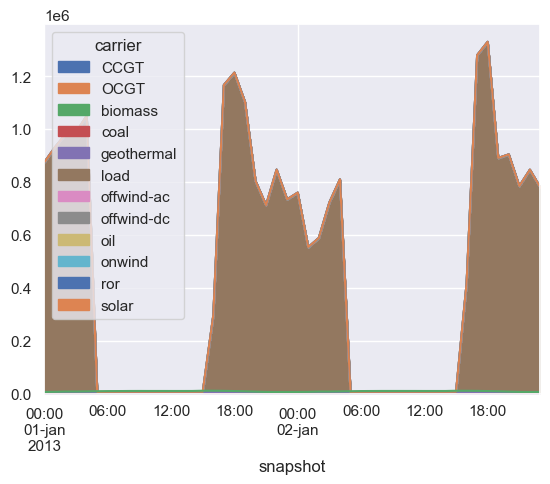

In [43]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.generators_t.p.loc[date1:date2].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

In [26]:
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"]   #constraint
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"].groupby(n.generators.carrier, axis=1).mean()  #resource availability
n.generators.marginal_cost 

curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment.loc["2013-01-01 06:00":"2013-01-01 15:00"].sum(axis=1)

n.generators_t.p.loc[:, n.generators.carrier == "load"].loc["2013-01-01 06:00":"2013-01-01 15:00"]   #load shedding



n.generators[["p_nom", "p_nom_opt"]]    #status

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\2573341186.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



,p_nom,p_nom_opt
Generator,,
C31,9.000000e+00,9.010932e+00
C32,1.500000e+00,2.296287e+00
C33,1.020000e+02,1.020278e+02
C34,1.890000e+02,1.896485e+02
C35,1.290000e+02,1.290000e+02
...,...,...
79 load,1.000000e+09,1.000000e+09
80 load,1.000000e+09,1.000000e+09
81 load,1.000000e+09,1.000000e+09


In [27]:
expanded_generators = n.generators[n.generators["p_nom_opt"] > n.generators["p_nom"] * 2]
print(expanded_generators[["carrier", "p_nom", "p_nom_opt"]])

                  carrier  p_nom    p_nom_opt
Generator                                    
C39                  CCGT   18.0    70.131714
C40                  CCGT    4.0   104.932329
C47                   oil    2.0    13.149888
C55            geothermal   40.0  2829.068993
C60            geothermal    5.0  2666.753566
...                   ...    ...          ...
37 offwind-ac  offwind-ac    0.0     0.250187
38 offwind-ac  offwind-ac    0.0     0.253420
39 offwind-ac  offwind-ac    0.0     0.230398
50 offwind-ac  offwind-ac    0.0     0.239781
75 offwind-ac  offwind-ac    0.0     0.242898

[137 rows x 3 columns]


In [28]:
print(expanded_generators[["carrier", "marginal_cost"]])



                  carrier  marginal_cost
Generator                               
C39                  CCGT      46.813905
C40                  CCGT      46.812223
C47                   oil     157.534321
C55            geothermal       0.009134
C60            geothermal       0.009110
...                   ...            ...
37 offwind-ac  offwind-ac       0.025641
38 offwind-ac  offwind-ac       0.024620
39 offwind-ac  offwind-ac       0.025174
50 offwind-ac  offwind-ac       0.025426
75 offwind-ac  offwind-ac       0.024574

[137 rows x 2 columns]


In [29]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
print(curtailment.loc[:, expanded_generators.index].sum(axis=1))

snapshot
2013-01-01 00:00:00      49.682935
2013-01-01 01:00:00      37.429618
2013-01-01 02:00:00      74.746661
2013-01-01 03:00:00     348.963962
2013-01-01 04:00:00     163.632193
                          ...     
2013-12-31 19:00:00    1804.691630
2013-12-31 20:00:00    1823.865345
2013-12-31 21:00:00    1479.464076
2013-12-31 22:00:00     949.419940
2013-12-31 23:00:00     835.102124
Length: 8760, dtype: float64


In [30]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment_expanded = curtailment.loc[:, expanded_generators.index]
print(curtailment_expanded.sum(axis=1).describe())  # Summary of curtailment

total_potential_generation = (n.generators_t.p_max_pu * n.generators.p_nom_opt).loc[:, expanded_generators.index].sum(axis=1)
curtailment_percentage = (curtailment_expanded.sum(axis=1) / total_potential_generation) * 100
print(curtailment_percentage)  # Percentage of curtailment

count      8760.000000
mean      31422.101513
std       30765.675539
min           0.039574
25%        5814.734128
50%       17752.450458
75%       56654.060524
max      127706.379225
dtype: float64
snapshot
2013-01-01 00:00:00    78.844272
2013-01-01 01:00:00    72.631303
2013-01-01 02:00:00    41.298186
2013-01-01 03:00:00    76.531415
2013-01-01 04:00:00    55.664508
                         ...    
2013-12-31 19:00:00    92.683080
2013-12-31 20:00:00    93.906726
2013-12-31 21:00:00    93.177058
2013-12-31 22:00:00    89.976694
2013-12-31 23:00:00    88.475113
Length: 8760, dtype: float64


In [31]:
demand = n.loads_t.p_set.sum(axis=1)
curtailment_vs_demand = pd.DataFrame({
    "curtailment": curtailment_expanded.sum(axis=1),
    "demand": demand
})
print(curtailment_vs_demand.corr())  # Correlation between curtailment and demand

             curtailment    demand
curtailment     1.000000  0.390229
demand          0.390229  1.000000


In [32]:
high_curtailment_hours = curtailment_expanded.sum(axis=1).nlargest(10)
print(high_curtailment_hours)

snapshot
2013-08-26 08:00:00    127706.379225
2013-08-26 09:00:00    127475.636125
2013-10-15 11:00:00    127424.930681
2013-10-16 10:00:00    125993.256539
2013-10-15 10:00:00    125241.294750
2013-10-16 09:00:00    121199.592788
2013-10-15 09:00:00    119682.570276
2013-08-26 10:00:00    119667.596810
2013-10-15 12:00:00    118214.902572
2013-08-25 09:00:00    117079.512384
dtype: float64


In [33]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator'], level=0)
storage_capacities

,,0
component,carrier,
StorageUnit,Reservoir & Dam,4340.625972


In [34]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Biomass                 1.130722e+01        1.050000e+01   
            Coal                    6.000053e+02        6.000000e+02   
            Combined-Cycle Gas      1.349813e+03        1.192700e+03   
            Geothermal              5.585823e+03        1.350000e+02   
            Offshore Wind (AC)      2.112695e+00        0.000000e+00   
            Offshore Wind (DC)      1.201364e+00        0.000000e+00   
            Oil                     1.017493e+02        8.880000e+01   
            Onshore Wind            1.722771e+05        9.110989e-01   
            Open-Cycle Gas          1.850376e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   1.490991e+05        1.447202e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      6.476920e+04        3.258621e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Biomass             7.245666e+03  0.000000e+00  7.245666e+03   
            Coal                7.086367e+02  0.000000e+00  7.086367e+02   
            Combined-Cycle Gas  2.086399e+06  0.000000e+00  2.086399e+06   
            Geothermal          4.489858e+07  0.000000e+00  4.489858e+07   
            Offshore Wind (AC)  1.740456e+03  0.000000e+00  1.740456e+03   
            Offshore Wind (DC)  1.428046e+03  0.000000e+00  1.428046e+03   
            Oil                 3.137482e+03  0.000000e+00  3.137482e+03   
            Onshore Wind        4.185343e+06  0.000000e+00  4.185343e+06   
            Open-Cycle Gas      2.773523e+03  0.000000e+00  2.773523e+03   
            Run of River        2.978206e+06  0.000000e+00  2.978206e+06   
            Solar               5.730443e+06  0.000000e+00  5.730443e+06   
            load                1.629190e+06  0.000000e+00  1.629190e+06   
Line        AC                  3.175737e+08  3.175737e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.732481e+07  0.000000e+00  1.732481e+07   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Biomass             0.000000e+00         0.073151  0.000000e+00   
            Coal                0.000000e+00         0.000135  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.176449  0.000000e+00   
            Geothermal          0.000000e+00         0.917574  0.000000e+00   
            Offshore Wind (AC)  0.000000e+00         0.094042  1.848555e+03   
            Offshore Wind (DC)  0.000000e+00         0.135695  1.552604e+03   
            Oil                 0.000000e+00         0.003520  0.000000e+00   
            Onshore Wind        0.000000e+00         0.002773  6.893461e+07   
            Open-Cycle Gas      0.000000e+00         0.001711  0.000000e+00   
            Run of River        0.000000e+00         0.564948  9.969345e+04   
            Solar               0.000000e+00         0.004387  2.063289e+08   
            load                0.000000e+00         0.000003  0.000000e+00   
Line        AC                 -2.733929e+07         0.559721  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.455630  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Biomass                    4.000420e+06             1.147618e+05   
            Coal                       2.649019e+08             2.283526e+04   
            Combined-Cycle Gas         1.703219e+08             9.766965e+07   
            Geothermal                 0.000000e+00             4.095926e+05 

Dispatch

In [35]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\2440099205.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier
CCGT          2.086399e+06
OCGT          2.773523e+03
biomass       7.245666e+03
coal          7.086367e+02
geothermal    4.489858e+07
load          1.629190e+09
offwind-ac    1.740456e+03
offwind-dc    1.428046e+03
oil           3.137482e+03
onwind        4.185343e+06
ror           2.978206e+06
solar         5.730443e+06
dtype: float64

In [36]:
#installed capacity p_nom= nominal power (MW) and p_nom_opt= optimized nominal power (MW)

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  1.349813e+03
OCGT        1.850000e+02  1.850376e+02
biomass     1.050000e+01  1.130722e+01
coal        6.000000e+02  6.000053e+02
geothermal  1.350000e+02  5.585823e+03
load        6.700000e+10  6.700000e+10
offwind-ac  0.000000e+00  2.112695e+00
offwind-dc  0.000000e+00  1.201364e+00
oil         8.880000e+01  1.017493e+02
onwind      9.110989e-01  1.722771e+05
ror         6.017862e+02  6.017862e+02
solar       1.447202e+01  1.490991e+05

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


C:\Users\hie\AppData\Local\Temp\ipykernel_15080\1217743023.py:23: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\1217743023.py:36: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\1217743023.py:45: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



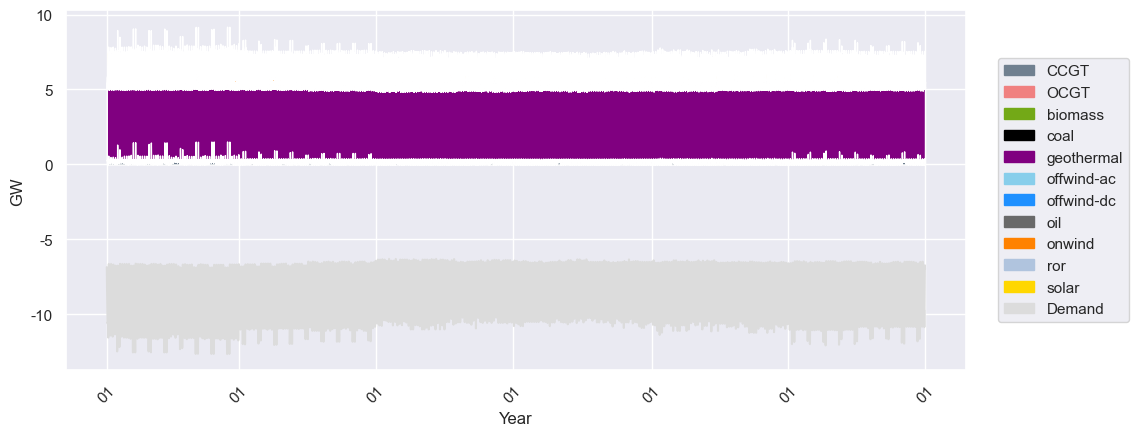

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  1.349813e+03
OCGT        1.850000e+02  1.850376e+02
biomass     1.050000e+01  1.130722e+01
coal        6.000000e+02  6.000053e+02
geothermal  1.350000e+02  5.585823e+03
load        6.700000e+10  6.700000e+10
offwind-ac  0.000000e+00  2.112695e+00
offwind-dc  0.000000e+00  1.201364e+00
oil         8.880000e+01  1.017493e+02
onwind      9.110989e-01  1.722771e+05
ror         6.017862e+02  6.017862e+02
solar       1.447202e+01  1.490991e+05


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-01-01"
second_date = "2014-01-01"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar + curtailment_wind

#Hourly generation per technology
CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]


#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = CCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = None

if "OCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
else:
    OCGT = None
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    


#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 



# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])


CCGT_color='slategrey'
Onwind_color='#ff8200'

Solar_color='gold'
curtailment_color = 'maroon'
ror_color='lightsteelblue'
reservoir_color='steelblue'
battery_color='tan'
oil_color='dimgrey'
biomass_color='#73A917'
demand_color='gainsboro'
lostload_color = "maroon"

# Prepare data for stackplot
stack_data = [CCGT, Onwind, solar, curtailment, ror, reservoir, pbattery, oil, load]
stack_colors = [CCGT_color, Onwind_color, Solar_color, curtailment_color, ror_color, reservoir_color, battery_color, oil_color, demand_color]

if biomass is not None:
    stack_data.append(biomass)
    stack_colors.append(biomass_color)

if OCGT is not None:
    stack_data.append(OCGT)
    stack_colors.append('lightcoral')

# Create the stackplot
plt.stackplot(CCGT.index, *stack_data, colors=stack_colors, zorder=3)


plt.stackplot(CCGT.index,demand,nbattery, colors=[demand_color,battery_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Year')


CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')

battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')

lostload_patch = mpatches.Patch(color=demand_color, label ='LostLoad')

handles = [
    CCGT_patch, wind_patch, solar_patch, curtailment_patch,
    ror_patch, reservoir_patch, oil_patch, load_patch, battery_patch
]

if biomass is not None:
    handles.append(biomass_patch)

if OCGT is not None:
    handles.append(mpatches.Patch(color='lightcoral', label='OCGT'))    

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = '.png' 


plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])


In [38]:
# List of generator carriers
generator_list = ["CCGT", "OCGT", "oil", "biomass", "geothermal", "onwind", "solar", "ror",""]

# Loop through each carrier in the generator list
for carrier in generator_list:
    # Filter generators by carrier and sum their generation
    if carrier in n.generators.carrier.unique():
        generation = n.generators_t.p.loc[:, n.generators[n.generators.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

# List of storage unit carriers
generator_list2 = ["hydro"]

# Loop through each carrier in the storage unit list
for carrier in generator_list2:
    # Filter storage units by carrier and sum their generation
    if carrier in n.storage_units.carrier.unique():
        generation = n.storage_units_t.p.loc[:, n.storage_units[n.storage_units.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

CCGT generation (MWh) = 2086399
OCGT generation (MWh) = 2774
oil generation (MWh) = 3137
biomass generation (MWh) = 7246
geothermal generation (MWh) = 44898576
onwind generation (MWh) = 4185343
solar generation (MWh) = 5730443
ror generation (MWh) = 2978206
 generation (MWh) = 0 (not present in the network)
hydro generation (MWh) = 17324809


Lost load

In [39]:
demand = n.loads_t.p_set.loc["2013"].sum(axis=1)
demand.idxmax()
demand.sum()

78849999.99998802

In [40]:
load_shedding = n.generators_t.p.loc["2013"].groupby(n.generators.carrier, axis=1).sum()["load"]
round(load_shedding.sum())

C:\Users\hie\AppData\Local\Temp\ipykernel_15080\1555212878.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



1629190377

In [41]:
#LL or Loadshedding is in kW/kWh 
lostload = n.generators_t.p.filter(like= "load")
#lostload.idxmax()
peakLL = pd.DataFrame(index = lostload.index)
peakLL["Peak LL"] = lostload.max(axis=1)/1000
sortedLL = peakLL.sort_values("Peak LL", ascending=False)
LL_contribution = sortedLL.iloc[0:9]
LL_contribution.mean()

Peak LL    616.817864
dtype: float64

In [42]:
#selecting generation capacities from statistics
# Load and process generation capacities
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line', 'Load', 'Link', 'Store'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0: "MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW'] / capacities['MW'].sum() * 100

# Define colors for each technology
H2_color = 'darkgoldenrod'
battery_color = 'tan'
demand_color = 'slategrey'
aggregated_small_capacities = 'black'

for i in range(len(capacities.index)):
    tech = capacities.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas":
        capacities.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas":
        capacities.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar":
        capacities.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River":
        capacities.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind":
        capacities.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam":
        capacities.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil":
        capacities.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal":
        capacities.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass":
        capacities.loc[tech, "Color"] = '#73A917'

# Handle small capacities
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), aggregated_small_capacities]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

# Plot installed capacities
plt.figure(figsize=(5, 5))
plt.pie(
    capacities['MW'], 
    labels=capacities.index, 
    colors=capacities['Color'], 
    autopct='%1.1f%%', 
    startangle=100, 
    pctdistance=0.85, 
    wedgeprops={'width': 0.4}
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

KeyError: "labels ['Link' 'Store'] not found in level"